In [4]:
import polars as pl
import buckaroo

Buckaroo has been enabled as the default DataFrame viewer.  To return to default dataframe visualization use `from buckaroo import disable; disable()`
must be running inside ipython to enable default display via enable()


In [14]:
fileLoc = r"C:\Users\Joshh\Projects\Stocks\Data\Integrated\enhanced_integrated_stock_sentiment_features.parquet"
df = pl.read_parquet(fileLoc)

In [ ]:
df.tail(20)

In [21]:
fileLoc2 = r"C:\Users\Joshh\Projects\Stocks\Data\sentiment_data_FINAL.parquet"
df2 = pl.read_parquet(fileLoc2)

In [ ]:
df2.head()

🔍 STOCK PRICE PREDICTION - CORRELATION ANALYSIS & FEATURE SELECTION
Loading data...
Data shape: (156385, 84)
Date range: 2017-01-03 to 2024-12-24
Unique symbols: 99

Generating target variables...
Data shape after target generation and cleaning: (156274, 88)
Removed 12 rows with infinite/extreme values (0.01%)

Direction distribution:
  neutral: 78,815 (50.43%)
  down: 38,657 (24.74%)
  up: 26,360 (16.87%)
  big_up: 12,442 (7.96%)

Performing correlation analysis...
Analyzing 80 numeric features...
Converting to pandas for correlation analysis...


C:\Users\Joshh\AppData\Local\Temp\ipykernel_62068\2849165074.py:105: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")


Final correlation dataset shape: (156274, 81)
Calculating correlations...

Top 20 features by absolute correlation with next_day_change_pct:
 1. intraday_return                0.1747
 2. daily_range                    0.1253
 3. macd_buy_signal                0.0982
 4. macd_sell_signal               0.0960
 5. rsi_14                         0.0906
 6. combined_sell_signal           0.0860
 7. volume_ratio                   0.0809
 8. market_news_volume_interaction 0.0770
 9. market_sentiment_volume_interaction 0.0611
10. rsi_buy_signal                 0.0566
11. combined_buy_signal            0.0520
12. sentiment_volume_interaction   0.0401
13. entity_sentiment_volume_interaction 0.0401
14. returns                        0.0396
15. news_volume_trading_interaction 0.0377
16. rsi_sell_signal                0.0324
17. volume                         0.0200
18. sentiment_7d_volatility        0.0182
19. entity_sentiment_7d_volatility 0.0182
20. market_sentiment_volatility_interaction 0.0167

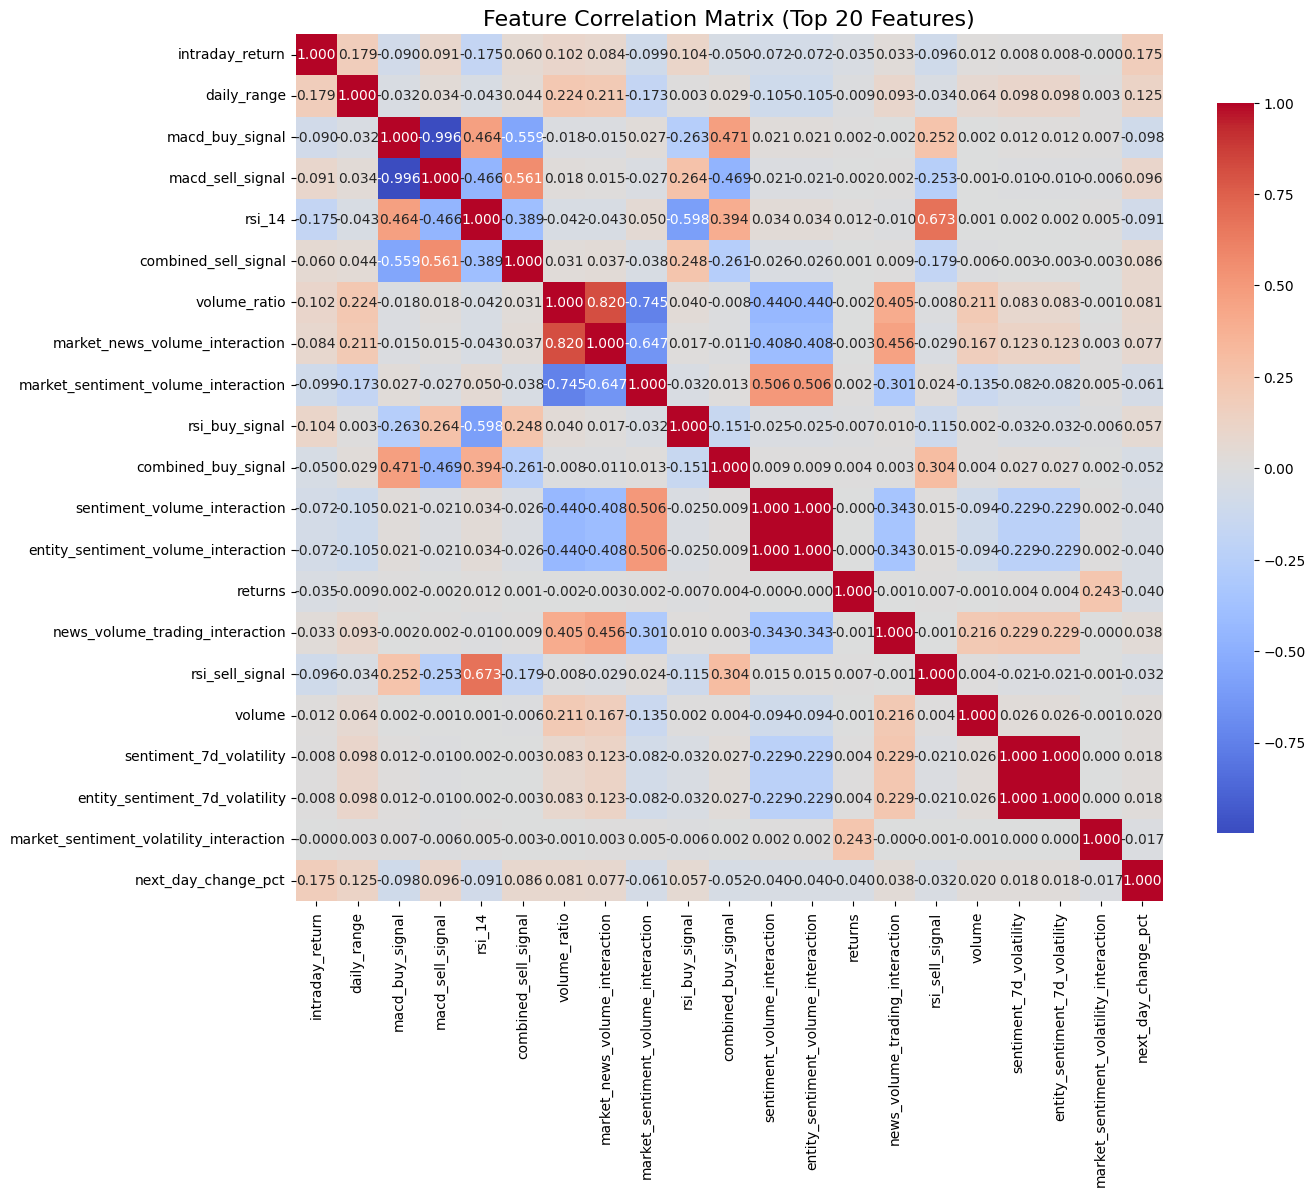

Generating feature importance plot...


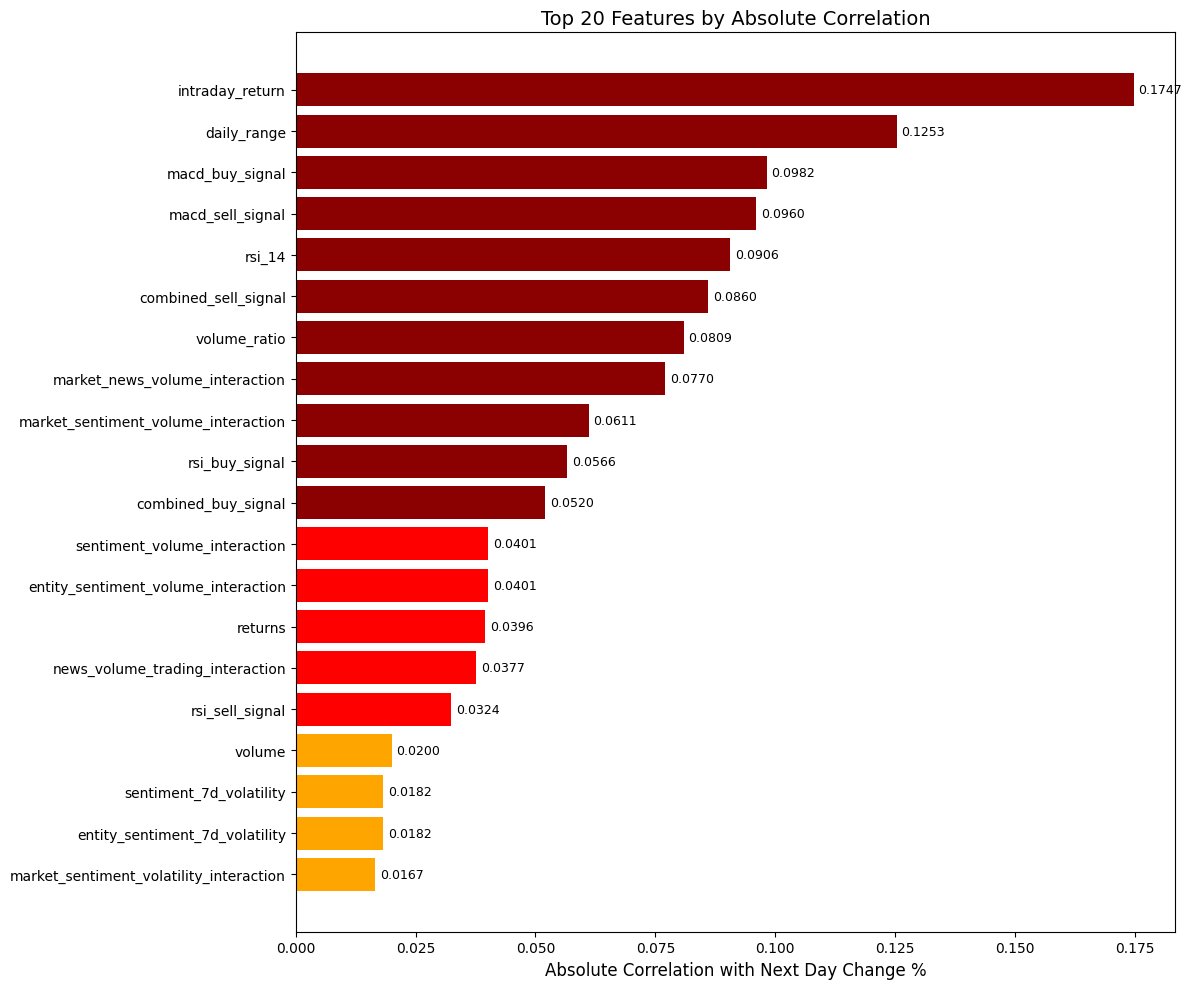

Generating distribution plots...


C:\Users\Joshh\AppData\Local\Temp\ipykernel_62068\2849165074.py:257: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  direction_counts_data = df_clean.group_by("direction_category").agg(pl.count().alias("count")).to_pandas()


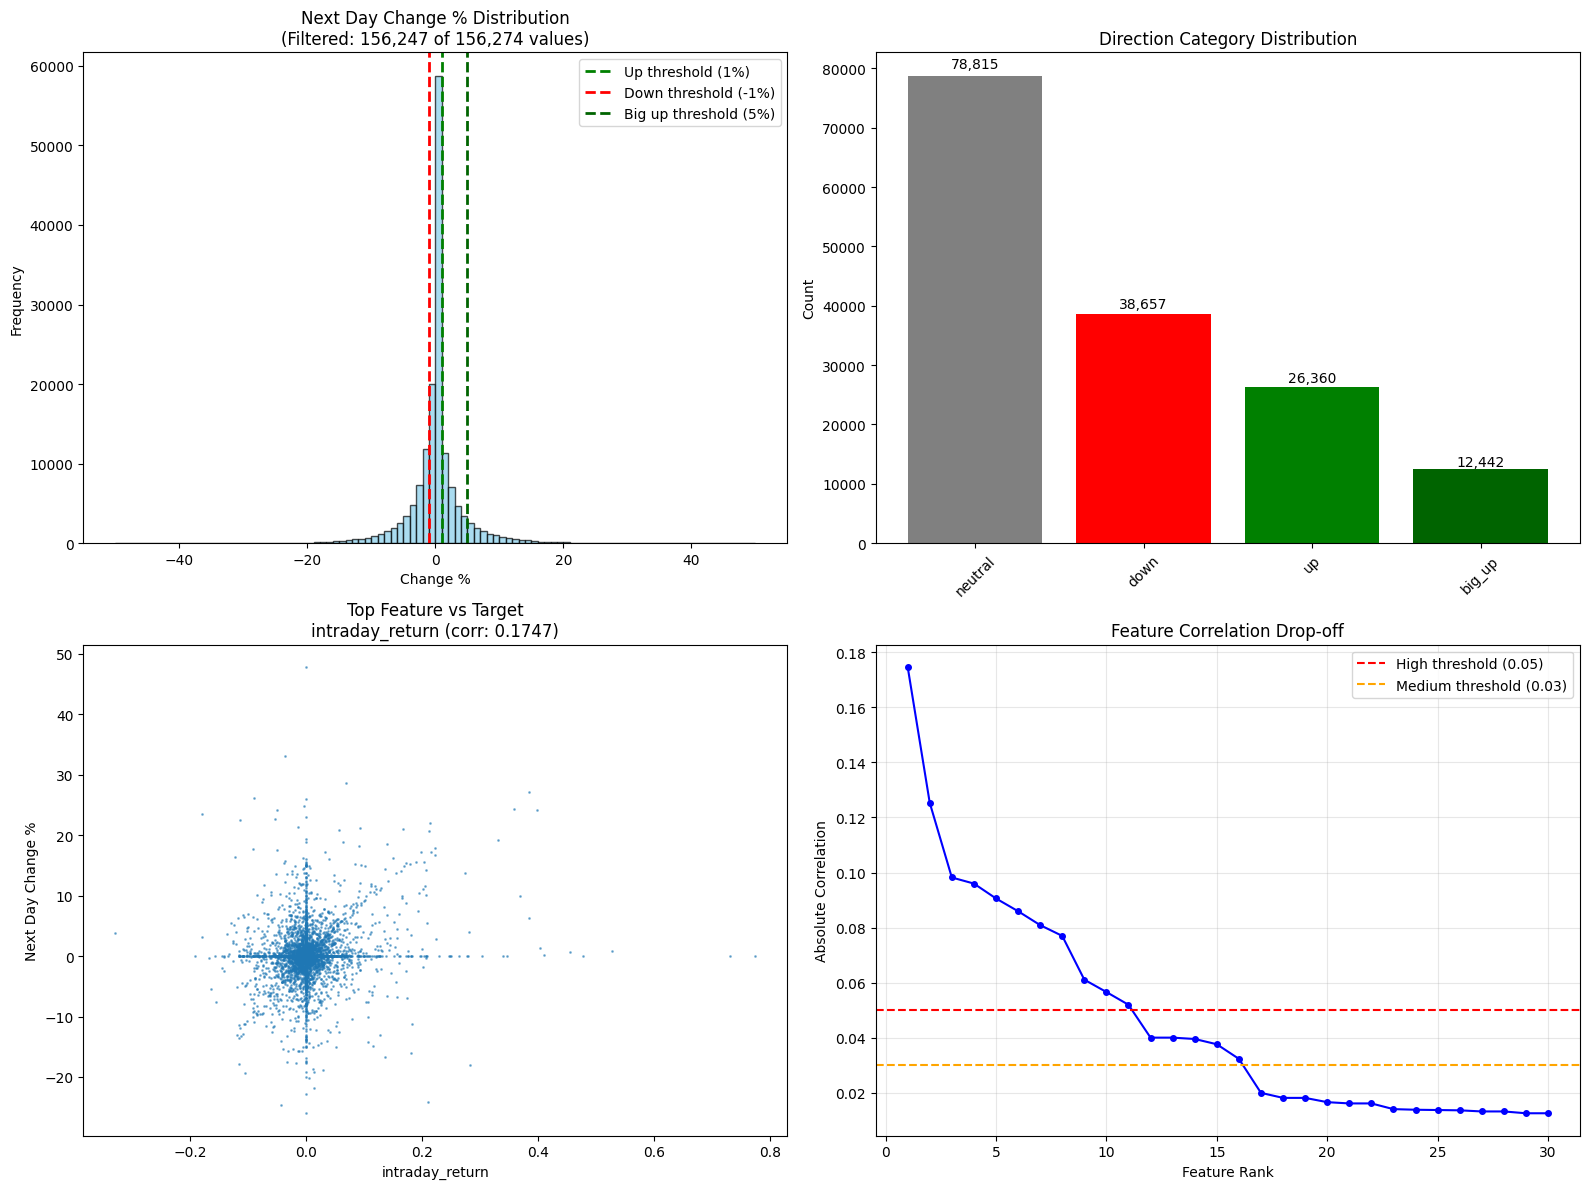


Saving processed data to C:\Users\Joshh\Projects\Stocks\stocks_with_targets.parquet

💾 Feature selection summary saved to: feature_selection_summary.json

📊 ANALYSIS SUMMARY
📈 Total samples: 156,274
🎯 Features selected: 16
🔧 Selection criteria: 0.03
📁 Data saved to: C:\Users\Joshh\Projects\Stocks\stocks_with_targets.parquet

🏆 TOP 10 SELECTED FEATURES:
 1. intraday_return                     (correlation: 0.1747)
 2. daily_range                         (correlation: 0.1253)
 3. macd_buy_signal                     (correlation: 0.0982)
 4. macd_sell_signal                    (correlation: 0.0960)
 5. rsi_14                              (correlation: 0.0906)
 6. combined_sell_signal                (correlation: 0.0860)
 7. volume_ratio                        (correlation: 0.0809)
 8. market_news_volume_interaction      (correlation: 0.0770)
 9. market_sentiment_volume_interaction (correlation: 0.0611)
10. rsi_buy_signal                      (correlation: 0.0566)
... and 6 more features


In [19]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

def generate_targets_and_analyze_correlations(data_path: str, output_path: str = None):
    """
    Generate target variables and perform correlation analysis for feature selection
    """
    
    print("Loading data...")
    # Handle both CSV and Parquet files
    try:
        if data_path.endswith('.parquet'):
            df = pl.read_parquet(data_path)
        elif data_path.endswith('.csv'):
            # Try different encodings if UTF-8 fails
            try:
                df = pl.read_csv(data_path)
            except:
                df = pl.read_csv(data_path, encoding="utf8-lossy")
        else:
            raise ValueError("Unsupported file format. Use .csv or .parquet")
    except Exception as e:
        print(f"Error reading file: {e}")
        print("Trying alternative encoding...")
        df = pl.read_csv(data_path, encoding="utf8-lossy")
    
    # Convert date column to datetime - handle different date formats
    try:
        df = df.with_columns(
            pl.col("date").str.to_datetime("%Y-%m-%d").alias("date")
        )
    except:
        try:
            df = df.with_columns(
                pl.col("date").str.to_datetime().alias("date")
            )
        except:
            # If date is already datetime, keep as is
            if df["date"].dtype == pl.Datetime:
                pass
            else:
                print("Warning: Could not parse date column, keeping original format")
    
    print(f"Data shape: {df.shape}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique symbols: {df['symbol'].n_unique()}")
    
    # Sort by symbol and date
    df = df.sort(["symbol", "date"])
    
    # Generate target variables
    print("\nGenerating target variables...")
    
    df = df.with_columns([
        # Next day closing price (regression target)
        pl.col("closing_price").shift(-1).over("symbol").alias("next_day_price"),
        
        # Price change percentage
        ((pl.col("closing_price").shift(-1).over("symbol") - pl.col("closing_price")) / 
         pl.col("closing_price") * 100).alias("next_day_change_pct"),
    ])
    
    # Generate direction categories
    df = df.with_columns([
        pl.when(pl.col("next_day_change_pct") > 5.0)
        .then(pl.lit("big_up"))
        .when(pl.col("next_day_change_pct") > 1.0)
        .then(pl.lit("up"))
        .when(pl.col("next_day_change_pct") < -1.0)
        .then(pl.lit("down"))
        .otherwise(pl.lit("neutral"))
        .alias("direction_category"),
        
        # Binary direction for simple classification
        pl.when(pl.col("next_day_change_pct") > 1.0)
        .then(1)
        .when(pl.col("next_day_change_pct") < -1.0)
        .then(0)
        .otherwise(None)
        .alias("direction_binary")
    ])
    
    # Remove rows where we can't calculate next day targets and clean extreme values
    df_clean = df.filter(
        pl.col("next_day_price").is_not_null() &
        pl.col("next_day_change_pct").is_not_null() &
        pl.col("next_day_change_pct").is_finite() &
        (pl.col("next_day_change_pct").abs() <= 100)  # Remove extreme outliers beyond ±100%
    )
    
    print(f"Data shape after target generation and cleaning: {df_clean.shape}")
    
    # Print statistics about removed data
    original_count = len(df.filter(pl.col("next_day_price").is_not_null()))
    removed_count = original_count - len(df_clean)
    if removed_count > 0:
        print(f"Removed {removed_count:,} rows with infinite/extreme values ({removed_count/original_count*100:.2f}%)")
    
    # Direction distribution
    direction_dist = df_clean.group_by("direction_category").agg(
        pl.count().alias("count")
    ).with_columns(
        (pl.col("count") / pl.col("count").sum() * 100).alias("percentage")
    ).sort("count", descending=True)
    
    print("\nDirection distribution:")
    for row in direction_dist.iter_rows(named=True):
        print(f"  {row['direction_category']}: {row['count']:,} ({row['percentage']:.2f}%)")
    
    # Feature correlation analysis
    print("\nPerforming correlation analysis...")
    
    # Select numeric columns for correlation (excluding target variables and identifiers)
    exclude_cols = ["date", "symbol", "next_day_price", "next_day_change_pct", 
                   "direction_category", "direction_binary"]
    
    numeric_cols = []
    for col in df_clean.columns:
        if col not in exclude_cols:
            dtype = df_clean[col].dtype
            if dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
                numeric_cols.append(col)
            # Also include boolean columns as they can be converted to numeric
            elif dtype == pl.Boolean:
                numeric_cols.append(col)
                # Convert boolean to int for correlation
                df_clean = df_clean.with_columns(pl.col(col).cast(pl.Int8))
    
    print(f"Analyzing {len(numeric_cols)} numeric features...")
    
    # Convert to pandas for correlation analysis (polars correlation is limited)
    print("Converting to pandas for correlation analysis...")
    df_corr = df_clean.select(numeric_cols + ["next_day_change_pct"]).to_pandas()
    
    # Handle any remaining non-numeric columns or infinite values
    df_corr = df_corr.replace([np.inf, -np.inf], np.nan)
    
    # Remove columns with too many NaN values (>50%)
    nan_threshold = 0.5
    initial_cols = len(df_corr.columns)
    df_corr = df_corr.dropna(axis=1, thresh=int(len(df_corr) * (1 - nan_threshold)))
    final_cols = len(df_corr.columns)
    
    if final_cols < initial_cols:
        print(f"Removed {initial_cols - final_cols} columns with >{nan_threshold*100}% missing values")
    
    # Remove rows with NaN in target variable
    df_corr = df_corr.dropna(subset=['next_day_change_pct'])
    
    print(f"Final correlation dataset shape: {df_corr.shape}")
    
    # Calculate correlations with target
    print("Calculating correlations...")
    correlations = df_corr.corr()["next_day_change_pct"].drop("next_day_change_pct")
    correlations = correlations.dropna()  # Remove any NaN correlations
    correlations_abs = correlations.abs().sort_values(ascending=False)
    
    print(f"\nTop 20 features by absolute correlation with next_day_change_pct:")
    for i, (feature, corr) in enumerate(correlations_abs.head(20).items(), 1):
        print(f"{i:2d}. {feature:<30} {corr:.4f}")
    
    # Select features using multiple criteria
    print("\nApplying feature selection criteria...")
    
    # Criteria 1: Correlation threshold
    threshold_high = 0.05
    threshold_medium = 0.03
    threshold_low = 0.02
    
    high_corr_features = correlations_abs[correlations_abs > threshold_high].index.tolist()
    medium_corr_features = correlations_abs[correlations_abs > threshold_medium].index.tolist()
    low_corr_features = correlations_abs[correlations_abs > threshold_low].index.tolist()
    
    print(f"Features with correlation > {threshold_high}: {len(high_corr_features)}")
    print(f"Features with correlation > {threshold_medium}: {len(medium_corr_features)}")
    print(f"Features with correlation > {threshold_low}: {len(low_corr_features)}")
    
    # Select final features (aim for 20-40 features)
    if len(high_corr_features) >= 15:
        selected_features = high_corr_features[:40]  # Take top 40 if we have enough high correlation features
        threshold_used = threshold_high
    elif len(medium_corr_features) >= 15:
        selected_features = medium_corr_features[:40]
        threshold_used = threshold_medium
    else:
        selected_features = correlations_abs.head(30).index.tolist()  # Take top 30 regardless of threshold
        threshold_used = "top_30"
    
    print(f"\nSelected {len(selected_features)} features using threshold: {threshold_used}")
    print("Selected features:")
    for i, feature in enumerate(selected_features, 1):
        corr_val = correlations_abs[feature]
        print(f"{i:2d}. {feature:<30} {corr_val:.4f}")
    
    # Create feature correlation heatmap
    print("\nGenerating correlation heatmap...")
    plt.figure(figsize=(14, 12))
    top_features = correlations_abs.head(20).index.tolist()
    corr_matrix = df_corr[top_features + ["next_day_change_pct"]].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', square=True, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix (Top 20 Features)', fontsize=16)
    plt.tight_layout()
    plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Feature importance plot
    print("Generating feature importance plot...")
    plt.figure(figsize=(12, 10))
    top_20_corr = correlations_abs.head(20)
    colors = ['darkred' if x > 0.05 else 'red' if x > 0.03 else 'orange' for x in top_20_corr.values]
    
    bars = plt.barh(range(len(top_20_corr)), top_20_corr.values, color=colors)
    plt.yticks(range(len(top_20_corr)), top_20_corr.index)
    plt.xlabel('Absolute Correlation with Next Day Change %', fontsize=12)
    plt.title('Top 20 Features by Absolute Correlation', fontsize=14)
    plt.gca().invert_yaxis()
    
    # Add correlation values as text
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.4f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Distribution analysis plots
    print("Generating distribution plots...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Next day change percentage distribution
    change_pct_data = df_clean['next_day_change_pct'].to_pandas().dropna()
    
    # Additional cleaning for visualization
    change_pct_clean = change_pct_data[(change_pct_data >= -50) & (change_pct_data <= 50)]
    
    if len(change_pct_clean) > 0:
        axes[0, 0].hist(change_pct_clean, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title(f'Next Day Change % Distribution\n(Filtered: {len(change_pct_clean):,} of {len(change_pct_data):,} values)', fontsize=12)
        axes[0, 0].axvline(x=1, color='green', linestyle='--', linewidth=2, label='Up threshold (1%)')
        axes[0, 0].axvline(x=-1, color='red', linestyle='--', linewidth=2, label='Down threshold (-1%)')
        axes[0, 0].axvline(x=5, color='darkgreen', linestyle='--', linewidth=2, label='Big up threshold (5%)')
        axes[0, 0].legend()
        axes[0, 0].set_xlabel('Change %')
        axes[0, 0].set_ylabel('Frequency')
    else:
        axes[0, 0].text(0.5, 0.5, 'No valid data for histogram', ha='center', va='center', transform=axes[0, 0].transAxes)
    
    # Direction category distribution
    direction_counts_data = df_clean.group_by("direction_category").agg(pl.count().alias("count")).to_pandas()
    direction_counts_data = direction_counts_data.sort_values('count', ascending=False)
    
    # Create color mapping for categories
    color_map = {'down': 'red', 'neutral': 'gray', 'up': 'green', 'big_up': 'darkgreen'}
    colors_cat = [color_map.get(cat, 'blue') for cat in direction_counts_data['direction_category']]
    
    bars = axes[0, 1].bar(direction_counts_data['direction_category'], direction_counts_data['count'], color=colors_cat)
    axes[0, 1].set_title('Direction Category Distribution', fontsize=12)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylabel('Count')
    
    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{int(height):,}', ha='center', va='bottom')
    
    # Feature correlation vs target (scatter plot of top feature)
    if len(selected_features) > 0:
        top_feature = selected_features[0]
        sample_size = min(5000, len(df_clean))
        sample_data = df_clean.sample(n=sample_size)
        
        x_data = sample_data[top_feature].to_pandas()
        y_data = sample_data['next_day_change_pct'].to_pandas()
        
        # Clean data for scatter plot
        valid_mask = np.isfinite(x_data) & np.isfinite(y_data) & (np.abs(y_data) <= 50)
        x_clean = x_data[valid_mask]
        y_clean = y_data[valid_mask]
        
        if len(x_clean) > 0:
            axes[1, 0].scatter(x_clean, y_clean, alpha=0.5, s=1)
            axes[1, 0].set_xlabel(top_feature)
            axes[1, 0].set_ylabel('Next Day Change %')
            axes[1, 0].set_title(f'Top Feature vs Target\n{top_feature} (corr: {correlations_abs[top_feature]:.4f})')
        else:
            axes[1, 0].text(0.5, 0.5, 'No valid data for scatter plot', ha='center', va='center', transform=axes[1, 0].transAxes)
    else:
        axes[1, 0].text(0.5, 0.5, 'No features selected', ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # Cumulative correlation plot
    cumulative_corr = correlations_abs.head(30)
    axes[1, 1].plot(range(1, len(cumulative_corr) + 1), cumulative_corr.values, 'bo-', markersize=4)
    axes[1, 1].axhline(y=threshold_high, color='red', linestyle='--', label=f'High threshold ({threshold_high})')
    axes[1, 1].axhline(y=threshold_medium, color='orange', linestyle='--', label=f'Medium threshold ({threshold_medium})')
    axes[1, 1].set_xlabel('Feature Rank')
    axes[1, 1].set_ylabel('Absolute Correlation')
    axes[1, 1].set_title('Feature Correlation Drop-off')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('target_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save processed data with targets
    if output_path:
        print(f"\nSaving processed data to {output_path}")
        if output_path.endswith('.parquet'):
            df_clean.write_parquet(output_path)
        else:
            df_clean.write_csv(output_path)
    
    # Create and save feature selection summary
    feature_summary = {
        'selected_features': selected_features,
        'correlation_threshold_used': str(threshold_used),
        'total_features_analyzed': len(numeric_cols),
        'features_selected': len(selected_features),
        'direction_distribution': direction_dist.to_pandas().to_dict('records'),
        'top_10_correlations': {
            feature: float(correlations_abs[feature]) 
            for feature in correlations_abs.head(10).index
        },
        'feature_categories': {
            'high_correlation': len(high_corr_features),
            'medium_correlation': len(medium_corr_features),
            'low_correlation': len(low_corr_features)
        }
    }
    
    # Save feature summary
    with open('feature_selection_summary.json', 'w') as f:
        json.dump(feature_summary, f, indent=2)
    
    print(f"\n💾 Feature selection summary saved to: feature_selection_summary.json")
    
    return df_clean, selected_features, feature_summary

if __name__ == "__main__":
    # Configuration
    data_path = r"C:\Users\Joshh\Projects\Stocks\Data\Integrated\enhanced_integrated_stock_sentiment_features.parquet"
    output_path = r"C:\Users\Joshh\Projects\Stocks\stocks_with_targets.parquet"
    
    print("🔍 STOCK PRICE PREDICTION - CORRELATION ANALYSIS & FEATURE SELECTION")
    print("="*80)
    
    # Run analysis
    df_processed, selected_features, summary = generate_targets_and_analyze_correlations(
        data_path, output_path
    )
    
    print("\n" + "="*80)
    print("📊 ANALYSIS SUMMARY")
    print("="*80)
    print(f"📈 Total samples: {len(df_processed):,}")
    print(f"🎯 Features selected: {len(selected_features)}")
    print(f"🔧 Selection criteria: {summary['correlation_threshold_used']}")
    print(f"📁 Data saved to: {output_path}")
    
    print(f"\n🏆 TOP 10 SELECTED FEATURES:")
    for i, feature in enumerate(selected_features[:10], 1):
        corr_val = summary['top_10_correlations'].get(feature, 0)
        print(f"{i:2d}. {feature:<35} (correlation: {corr_val:.4f})")
    
    if len(selected_features) > 10:
        print(f"... and {len(selected_features) - 10} more features")
    
    print(f"\n📊 DIRECTION DISTRIBUTION:")
    for item in summary['direction_distribution']:
        print(f"   {item['direction_category']:<10}: {item['count']:>6,} ({item['percentage']:>5.2f}%)")
    
    print(f"\n📁 GENERATED FILES:")
    print(f"   • {output_path}")
    print(f"   • feature_selection_summary.json")
    print(f"   • feature_correlation_heatmap.png")
    print(f"   • feature_importance.png") 
    print(f"   • target_analysis.png")
    
    print(f"\n✅ Correlation analysis completed successfully!")
    print(f"🎯 Ready for LSTM model training with {len(selected_features)} selected features")